In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks,Sequential
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import tensorflow as tf
from datetime import datetime
from prettytable import PrettyTable
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [3]:
#pjm_final = pd.read_pickle("final_pjm_data.pkl")
pjm_final = pd.read_pickle("/content/gdrive/MyDrive/Case Study 1/final_pjm_stationary.pkl")
pjm_final

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,,
2002-01-08 03:00:00,10.253299,0.297609,7.071068e-01,0.313937,0.707107,0.429240
2002-01-08 04:00:00,10.259167,0.291394,5.000000e-01,0.297609,0.866025,0.432506
2002-01-08 05:00:00,10.284045,0.294912,2.588190e-01,0.291394,0.965926,0.435912
2002-01-08 06:00:00,10.352938,0.310060,6.123234e-17,0.294912,1.000000,0.439369
2002-01-08 07:00:00,10.472658,0.354029,-2.588190e-01,0.310060,0.965926,0.443005
...,...,...,...,...,...,...
2018-08-02 20:00:00,10.693262,0.655156,5.000000e-01,0.678732,-0.866025,0.635333
2018-08-02 21:00:00,10.674914,0.621784,7.071068e-01,0.655156,-0.707107,0.632111
2018-08-02 22:00:00,10.634725,0.604909,8.660254e-01,0.621784,-0.500000,0.628587


In [4]:
def performance_metrics(y_actual,y_predict):
    y_actual = np.expm1(np.array(y_actual))
    y_predict = np.expm1(np.array(y_predict))
    mape = np.mean(np.abs((y_actual-y_predict)/y_actual))*100
    mae = mean_absolute_error(y_actual,y_predict)
    mse = mean_squared_error(y_actual,y_predict)
    rmse = sqrt(mean_squared_error(y_actual,y_predict))
    return rmse,mae,mape,mse

In [5]:
def result_visualization(y,y_hat,title=None):
    y = np.expm1(np.array(y))
    y_hat = np.expm1(np.array(y_hat))
    plt.figure(figsize=(23,5))
    plt.plot(y,label='true')
    plt.plot(y_hat,label='predicted')
    #plt.xlim(dt(2016, 1, 1),dt(2018, 12, 31))
    plt.legend()
    plt.grid()
    plt.title(title)
    
    plt.show()

In [6]:
pjm_df_copy = pjm_final.copy()
pjm_df_copy.head()

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,,
2002-01-08 03:00:00,10.253299,0.297609,7.071068e-01,0.313937,0.707107,0.429240
2002-01-08 04:00:00,10.259167,0.291394,5.000000e-01,0.297609,0.866025,0.432506
2002-01-08 05:00:00,10.284045,0.294912,2.588190e-01,0.291394,0.965926,0.435912
2002-01-08 06:00:00,10.352938,0.310060,6.123234e-17,0.294912,1.000000,0.439369
2002-01-08 07:00:00,10.472658,0.354029,-2.588190e-01,0.310060,0.965926,0.443005


# Univariate Time Series Analysis

Statistical way of Forecasting

In [9]:
#statistical method works well when dataset is small so taking test data as latest 100 hours and training data as former 900 hours

test_size = 100
df_train = pjm_df_copy[-1000:-test_size]#1191#5134 #-1000#-350
df_test = pjm_df_copy[-test_size:]
print('Type of df_train :',type(df_train))
print('Type of df_tesy :',type(df_test))
print(df_train.shape)
print(df_test.shape)

Type of df_train : <class 'pandas.core.frame.DataFrame'>
Type of df_tesy : <class 'pandas.core.frame.DataFrame'>
(900, 6)
(100, 6)


In [ ]:
train = df_train['PJME_MW']
test = df_test['PJME_MW']
print(type(train))
print(type(test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## 1. Exponential Weighted Average (Naive Model)

Exponential smoothing is a way to weight observations differently. Specifically, recent observations are weighted moreso than more distant ones. This makes intuitive sense.By applying unequal weights to past observations, we can control how much each affects the future forecast.
The formulation is this: $S_{t} = \alpha*y_{t-1} + \alpha(1-\alpha)S_{t-1} + \alpha(1-\alpha)^2S_{t-1} +$ ...

$S_{t}$ is the smoothed value at time *t*  
$\alpha$ is a smoothing constant  
$y_{t-1}$ is the value of the series at time *t-1*

##### Three Types of Exponential Smoothing

There are three key exponential smoothing techniques you need to be aware of:
1. Single Exponential Smoothing - no trend or seasonality
2. Double Exponential Smoothing - captures trend
3. Triple Exponential Smoothing - captures trend & seasonality

##### Single Exponential
This method is useful if your data lacks trend and seasonality and you want to approximately track patterns in your data. Furthermore, this method removes the lag associated with the moving average techniques discussed above. 

##### Double Exponential 
Should your data exhibit a trend, you'll want to use this smoothing method. It has all the benefits of Single Exponential with the ability to pickup on trend. 

##### Triple Exponential
Should your data exhibit trend and seasonality, you'll want to use this smoothing method. It has all the benefits of Double Exponential with the ability to pickup on seasonality.<br>

we will go for triple exponential method


### Single Exponential Smoothing (Base Model)

In [ ]:
single_exp = SimpleExpSmoothing(train)
single_exp_fit = single_exp.fit(optimized=True)
single_exp_pred = single_exp_fit.forecast(len(test))


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.573622
2018-07-29 22:00:00   10.507312        10.573622
2018-07-29 23:00:00   10.426676        10.573622
2018-07-30 00:00:00   10.334945        10.573622
2018-07-30 01:00:00   10.253792        10.573622
****************************************************************************************************
RSME : 7092.239514143028
MAE : 5901.140006687816
MAPE : 18.035500107771206
MSE : 50299861.32597173


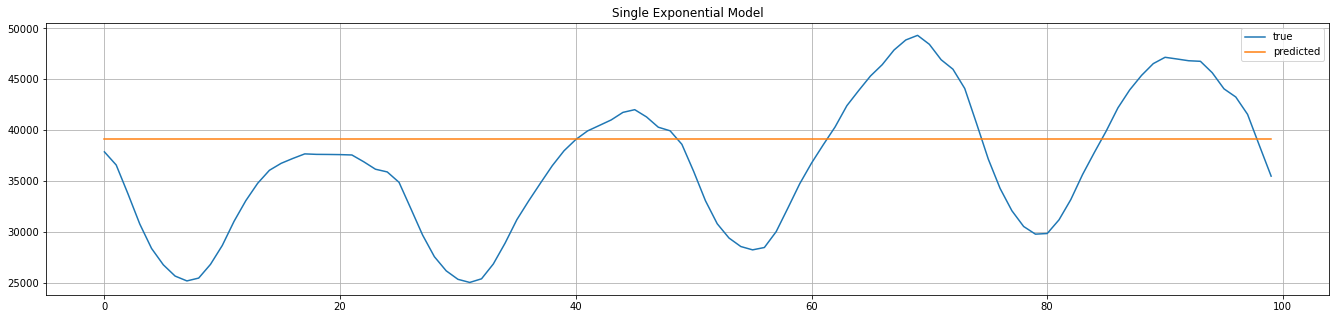

In [ ]:
single_exp_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
single_exp_model['True_value'] = test 
single_exp_model['Predicted_value'] = single_exp_pred
print(single_exp_model.head())
########################################################
print('*'*100)

rmse_single,mae_single,mape_single,mse_single = performance_metrics(single_exp_model.True_value,single_exp_model.Predicted_value)
print('RSME :',rmse_single)
print('MAE :',mae_single)
print('MAPE :',mape_single)
print('MSE :',mse_single)
########################################################

result_visualization(single_exp_model.True_value,single_exp_model.Predicted_value,title='Single Exponential Model')

### Double Exponential smoothing

In [ ]:
double_exp = Holt(train)
double_exp_fit = double_exp.fit(optimized=True)
double_exp_pred = double_exp_fit.forecast(len(test))

                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.537742
2018-07-29 22:00:00   10.507312        10.501863
2018-07-29 23:00:00   10.426676        10.465983
2018-07-30 00:00:00   10.334945        10.430103
2018-07-30 01:00:00   10.253792        10.394224
****************************************************************************************************
RSME : 29785.363733343846
MAE : 26662.482670541915
MAPE : 69.99438476293278
MSE : 887167892.7275947


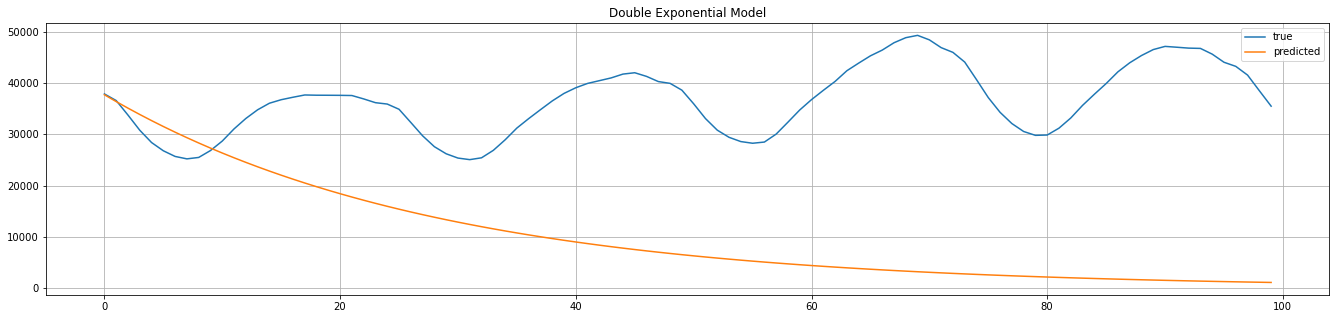

In [ ]:
double_exp_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
double_exp_model['True_value'] = test 
double_exp_model['Predicted_value'] = double_exp_pred
print(double_exp_model.head())
########################################################
print('*'*100)

rmse_double,mae_double,mape_double,mse_double = performance_metrics(double_exp_model.True_value,double_exp_model.Predicted_value)
print('RSME :',rmse_double)
print('MAE :',mae_double)
print('MAPE :',mape_double)
print('MSE :',mse_double)
########################################################

result_visualization(double_exp_model.True_value,double_exp_model.Predicted_value,title='Double Exponential Model')

### Triple Exponential Smoothing

In [ ]:
triple_exp = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=48)
triple_exp_fit = triple_exp.fit(optimized=True)
triple_exp_pred = triple_exp_fit.forecast(len(test))

                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.542339
2018-07-29 22:00:00   10.507312        10.510864
2018-07-29 23:00:00   10.426676        10.438963
2018-07-30 00:00:00   10.334945        10.355379
2018-07-30 01:00:00   10.253792        10.274933
****************************************************************************************************
RSME : 4069.1046131124053
MAE : 3364.4508807626644
MAPE : 8.771581280488563
MSE : 16557612.352452658


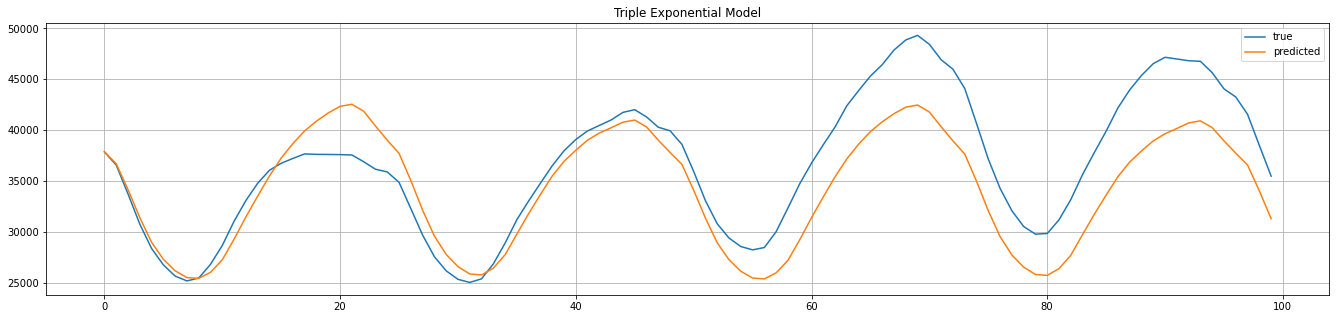

In [ ]:
triple_exp_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
triple_exp_model['True_value'] = test 
triple_exp_model['Predicted_value'] = triple_exp_pred
print(triple_exp_model.head())
########################################################
print('*'*100)

rmse_triple,mae_triple,mape_triple,mse_triple = performance_metrics(triple_exp_model.True_value,triple_exp_model.Predicted_value)
print('RSME :',rmse_triple)
print('MAE :',mae_triple)
print('MAPE :',mape_triple)
print('MSE :',mse_triple)
########################################################

result_visualization(triple_exp_model.True_value,triple_exp_model.Predicted_value,title='Triple Exponential Model')

## AR Model without Differencing

**Autocorrelation:** a variable's correlation with itself at different lags.

AR models regress on actual past values 

This is the first order or **AR(1)** formula which is: $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$

The $\beta$'s are just like those in linear regression and $\epsilon$ is irreducible error.

A second order or **AR(2)** would look like : $y_t = \beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$

The pattern of adding another coefficient and another past term continues to whichever order you choose. Choosing that order called *p* .

In [ ]:
%%time
ar1_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  ar1_model = ARMA(train,order=(2,0))
  ar1_model_fit = ar1_model.fit(disp=0)
  ar1_pred = ar1_model_fit.forecast()
  ar1_predictions.append(ar1_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]

Wall time: 29.6 s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.534344
2018-07-29 22:00:00   10.507312        10.508265
2018-07-29 23:00:00   10.426676        10.472571
2018-07-30 00:00:00   10.334945        10.352117
2018-07-30 01:00:00   10.253792        10.254366
****************************************************************************************************
RSME : 526.0661840491175
MAE : 392.75
MAPE : 1.0890645002386443
MSE : 276745.63


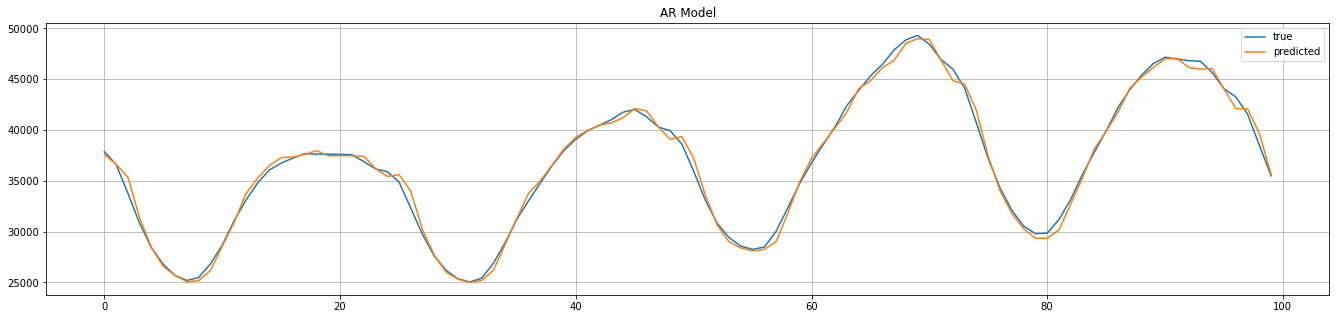

In [ ]:
autoregression_model1 = pd.DataFrame(columns = ['True_value','Predicted_value'])
autoregression_model1['True_value'] = test 
autoregression_model1['Predicted_value'] = ar1_predictions
print(autoregression_model1.head())
########################################################
print('*'*100)

rmse_ar1,mae_ar1,mape_ar1,mse_ar1 = performance_metrics(autoregression_model1.True_value,autoregression_model1.Predicted_value)
print('RSME :',rmse_ar1)
print('MAE :',mae_ar1)
print('MAPE :',mape_ar1)
print('MSE :',mse_ar1)
########################################################

result_visualization(autoregression_model1.True_value,autoregression_model1.Predicted_value,title='AR Model')

## MA without differencing

### MA Model Specifics
A MA model is defined by this equation: $y_t=c+e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$ where $e_t$ is white noise. The value $c$ is a constant value and the $\theta$'s are coefficients, not unlike those found in linear regression.

### MA Models != Moving Average Smoothing
An important distinction is that a moving average model is not the same thing as moving average smoothing. 

Moving average smoothing is useful for estimating trend and seasonality of past data. MA models, on the other hand, are a useful forecasting model that regresses on past forecast errors in order to forecast future values. <br>
Some things to note:
1. MA models do not propagate shocks infinitely; they die after `q` lags represented as MA(q).
1. If a process depends on previous values of itself, then it is an AR process. If it depends on previous errors, then it is an MA process.
1. MA processes will exhibit exponential decay in PACF and a cut-off in ACF

In [ ]:
%%time
ma1_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  ma1_model = ARMA(train,order=(0,1))
  ma1_model_fit = ma1_model.fit(disp=0)
  ma1_pred = ma1_model_fit.forecast()
  ma1_predictions.append(ma1_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]

Wall time: 12.6 s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.463805
2018-07-29 22:00:00   10.507312        10.550034
2018-07-29 23:00:00   10.426676        10.433278
2018-07-30 00:00:00   10.334945        10.468137
2018-07-30 01:00:00   10.253792        10.345649
****************************************************************************************************
RSME : 3559.060891583621
MAE : 2953.37
MAPE : 8.12719717151913
MSE : 12666914.43


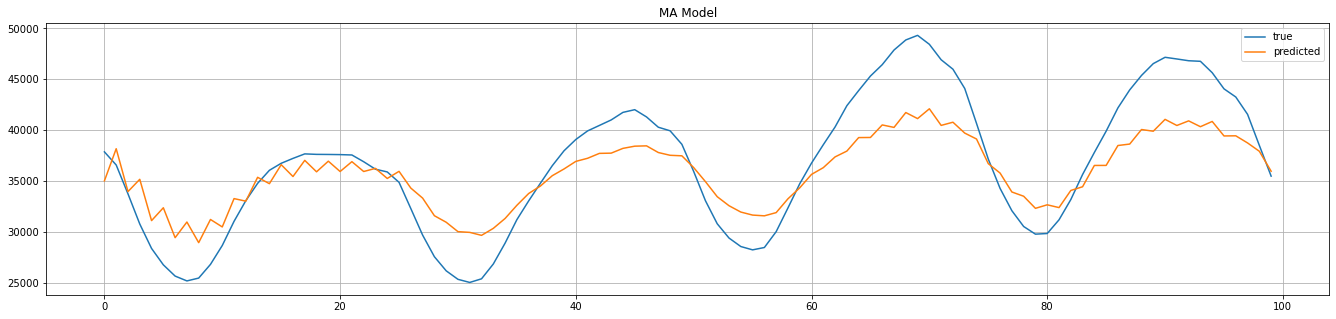

In [ ]:
movingaverage_model1 = pd.DataFrame(columns = ['True_value','Predicted_value'])
movingaverage_model1['True_value'] = test 
movingaverage_model1['Predicted_value'] = ma1_predictions
print(movingaverage_model1.head())

#####################################################
print('*'*100)
rmse_ma1,mae_ma1,mape_ma1,mse_ma1 = performance_metrics(movingaverage_model1.True_value,movingaverage_model1.Predicted_value)
print('RSME :',rmse_ma1)
print('MAE :',mae_ma1)
print('MAPE :',mape_ma1)
print('MSE :',mse_ma1)

##########################################################

result_visualization(movingaverage_model1.True_value,movingaverage_model1.Predicted_value,title='MA Model')

## ARMA Model

In [ ]:
%%time
arma1_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  arma1_model = ARMA(train,order=(5,2))
  arma1_model_fit = arma1_model.fit(disp=0)
  arma1_pred = arma1_model_fit.forecast()
  arma1_predictions.append(arma1_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:02<00:00,  3.62s/it]

Wall time: 6min 2s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.409305
2018-07-29 22:00:00   10.507312        10.651146
2018-07-29 23:00:00   10.426676        10.425883
2018-07-30 00:00:00   10.334945        10.370001
2018-07-30 01:00:00   10.253792        10.268400
****************************************************************************************************
RSME : 874.6432587060852
MAE : 454.01
MAPE : 1.2289845082815287
MSE : 765000.83


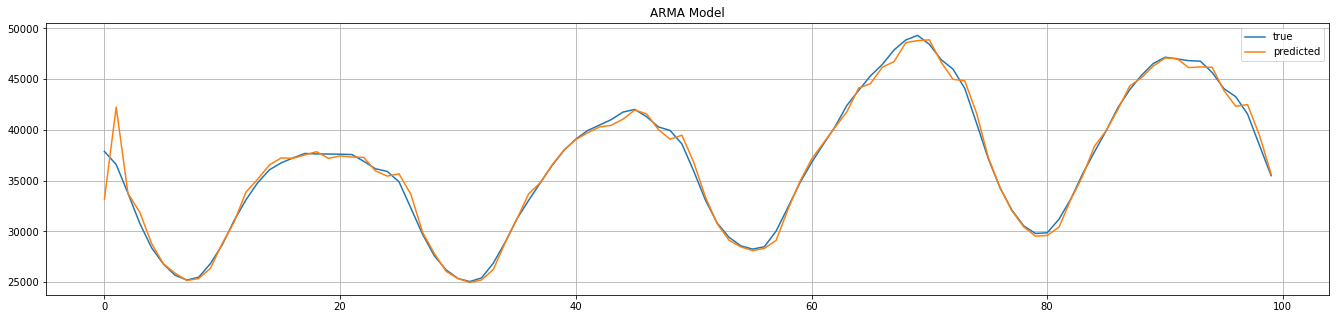

In [ ]:
movingaverage_model2 = pd.DataFrame(columns = ['True_value','Predicted_value'])
movingaverage_model2['True_value'] = test 
movingaverage_model2['Predicted_value'] = arma1_predictions
print(movingaverage_model2.head())
##########################################
print('*'*100)
rmse_arma1,mae_arma1,mape_arma1,mse_arma1 = performance_metrics(movingaverage_model2.True_value,movingaverage_model2.Predicted_value)
print('RSME :',rmse_arma1)
print('MAE :',mae_arma1)
print('MAPE :',mape_arma1)
print('MSE :',mse_arma1)

#############################################

result_visualization(movingaverage_model2.True_value,movingaverage_model2.Predicted_value,title='ARMA Model')

## AR Model with Differencing

In [ ]:
%%time
ar_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  ar_model = ARIMA(train,order=(5,1,0))
  ar_model_fit = ar_model.fit(disp=0)
  ar_pred = ar_model_fit.forecast()
  ar_predictions.append(ar_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.13it/s]

Wall time: 47 s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.411223
2018-07-29 22:00:00   10.507312        10.654164
2018-07-29 23:00:00   10.426676        10.431018
2018-07-30 00:00:00   10.334945        10.359242
2018-07-30 01:00:00   10.253792        10.289468
****************************************************************************************************
RSME : 895.0689414788114
MAE : 476.27
MAPE : 1.3105491353656753
MSE : 801148.41


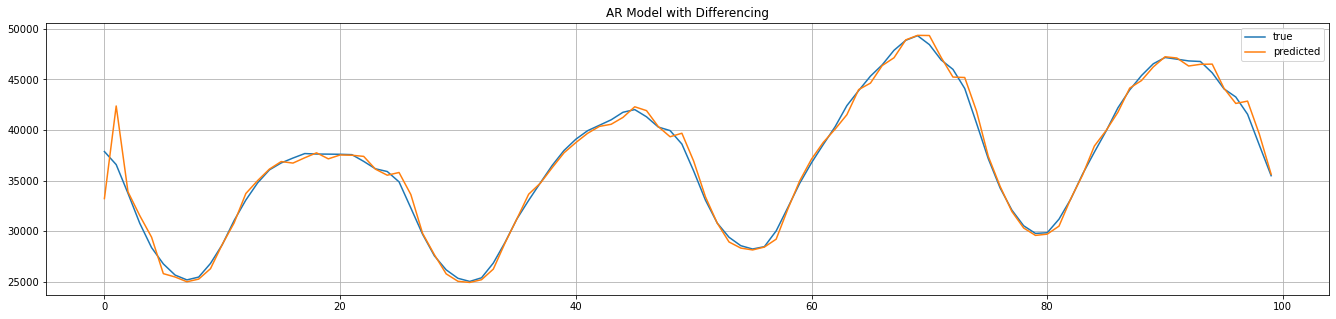

In [ ]:
autoregression_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
autoregression_model['True_value'] = test 
autoregression_model['Predicted_value'] = ar_predictions
print(autoregression_model.head())

#################
print('*'*100)

rmse_ar,mae_ar,mape_ar,mse_ar = performance_metrics(autoregression_model.True_value,autoregression_model.Predicted_value)
print('RSME :',rmse_ar)
print('MAE :',mae_ar)
print('MAPE :',mape_ar)
print('MSE :',mse_ar)
#######################

result_visualization(autoregression_model.True_value,autoregression_model.Predicted_value,title='AR Model with Differencing')


## MA Model with Differencing

In [ ]:
%%time
ma_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  ma_model = ARIMA(train,order=(0,2,4))
  ma_model_fit = ma_model.fit(disp=0)
  ma_pred = ma_model_fit.forecast()
  ma_predictions.append(ma_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.52it/s]

Wall time: 18.1 s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.395853
2018-07-29 22:00:00   10.507312        10.656501
2018-07-29 23:00:00   10.426676        10.431275
2018-07-30 00:00:00   10.334945        10.353079
2018-07-30 01:00:00   10.253792        10.257393
****************************************************************************************************
RSME : 951.9312895372228
MAE : 536.34
MAPE : 1.503878318306214
MSE : 906173.18


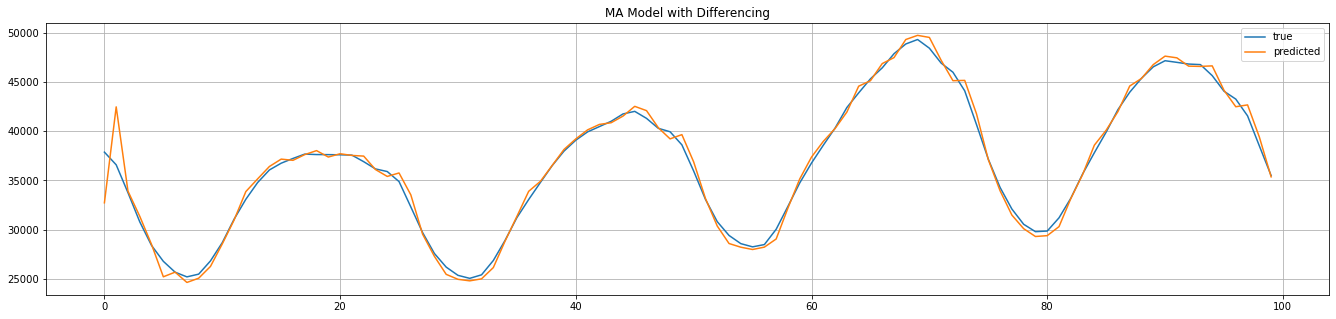

In [ ]:
movingaverage_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
movingaverage_model['True_value'] = test 
movingaverage_model['Predicted_value'] = ma_predictions
print(movingaverage_model.head())
############
print('*'*100)

rmse_ma,mae_ma,mape_ma,mse_ma = performance_metrics(movingaverage_model.True_value,movingaverage_model.Predicted_value)
print('RSME :',rmse_ma)
print('MAE :',mae_ma)
print('MAPE :',mape_ma)
print('MSE :',mse_ma)
###########

result_visualization(movingaverage_model.True_value,movingaverage_model.Predicted_value,title='MA Model with Differencing')


## ARIMA Model 

In ARIMA model,the I stands for "Integrated" which just refers to the amount of differcing done on the data.
<br>
When we are determining our ARIMA model we will come across the following standard inputs<br>
- order(p,d,q):
    - p is number of AR terms
    - d is number of times that we would difference our data
    - q is number of MA terms

In [ ]:
%%time
arma_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  arma_model = ARIMA(train,order=(4,1,2))
  arma_model_fit = arma_model.fit(disp=0)
  arma_pred = arma_model_fit.forecast()
  arma_predictions.append(arma_pred[0][0])
  train.append(test[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]

Wall time: 2min 24s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.411241
2018-07-29 22:00:00   10.507312        10.633903
2018-07-29 23:00:00   10.426676        10.440854
2018-07-30 00:00:00   10.334945        10.373547
2018-07-30 01:00:00   10.253792        10.271704
****************************************************************************************************
RSME : 844.3414475198999
MAE : 477.26
MAPE : 1.2980205833924574
MSE : 712912.48


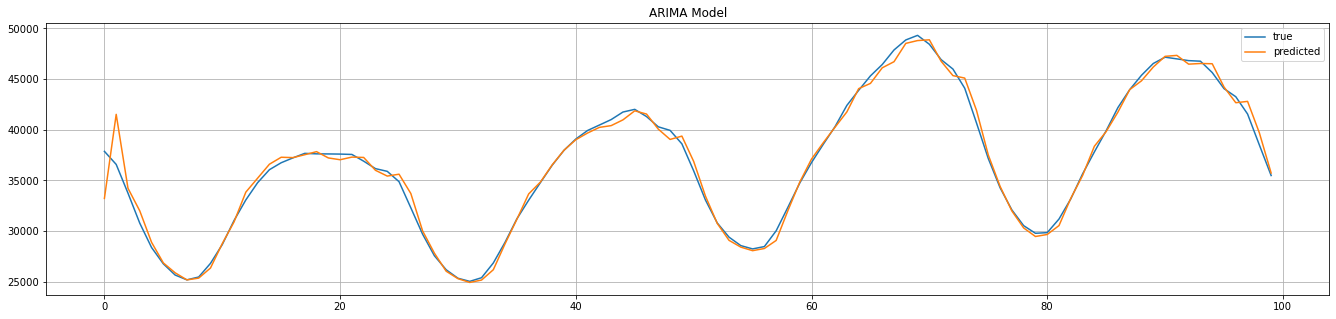

In [ ]:
arma_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
arma_model['True_value'] = test 
arma_model['Predicted_value'] = arma_predictions
print(arma_model.head())
############
print('*'*100)

rmse_arma,mae_arma,mape_arma,mse_arma = performance_metrics(arma_model.True_value,arma_model.Predicted_value)
print('RSME :',rmse_arma)
print('MAE :',mae_arma)
print('MAPE :',mape_arma)
print('MSE :',mse_arma)
###################

result_visualization(arma_model.True_value,arma_model.Predicted_value,title='ARIMA Model')

When we work with SARIMa model ,apart from the inputs used in ARIMA Model we have to pass extra inputs.
In SARIMA models 'S' refers to 'seasonal' and we have the additional standard inputs:
- seasonal order(p,d,q):
    - p is number of AR terms in regards to seasonal lag
    - d is number of times that we would difference our seasonal lag (as seen above)
    - q is number of MA terms in regards to seasonal lag
    - s is number of periods in a season

## SAR Model

In [ ]:
%%time
sar_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  sar_model = SARIMAX(train,order=(4,0,0),seasonal_order=(4,0,0,24), enforce_stationarity=False, enfore_invertibility=False)
  sar_model_fit = sar_model.fit()
  sar_pred = sar_model_fit.forecast()
  sar_predictions.append(sar_pred[0])
  train.append(test[i])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:29:13<00:00, 53.53s/it]

Wall time: 1h 29min 13s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.406231
2018-07-29 22:00:00   10.507312        10.622461
2018-07-29 23:00:00   10.426676        10.457813
2018-07-30 00:00:00   10.334945        10.365089
2018-07-30 01:00:00   10.253792        10.277904
****************************************************************************************************
RSME : 795.2549654041777
MAE : 435.6
MAPE : 1.2203428543972632
MSE : 632430.46


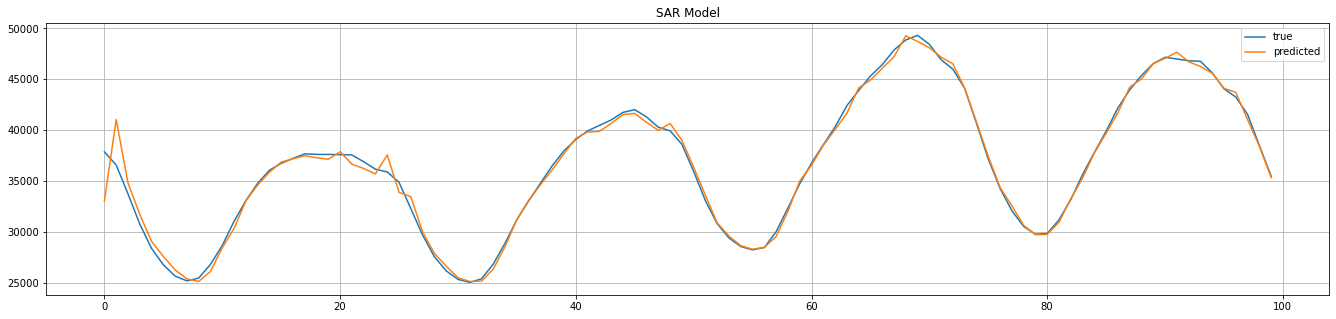

In [ ]:
sar_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
sar_model['True_value'] = test 
sar_model['Predicted_value'] = sar_predictions
print(sar_model.head())
########
print('*'*100)

rmse_sar,mae_sar,mape_sar,mse_sar = performance_metrics(sar_model.True_value,sar_model.Predicted_value)
print('RSME :',rmse_sar)
print('MAE :',mae_sar)
print('MAPE :',mape_sar)
print('MSE :',mse_sar)
###############

result_visualization(sar_model.True_value,sar_model.Predicted_value,title='SAR Model')

 ## SMA Model

In [ ]:
%%time
sma_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  sma_model = SARIMAX(train,order=(0,0,4),seasonal_order=(0,0,4,12), enforce_stationarity=False, enfore_invertibility=False)
  sma_model_fit = sma_model.fit()
  sma_pred = sma_model_fit.forecast()
  sma_predictions.append(sma_pred[0])
  train.append(test[i])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:41<00:00, 38.21s/it]

Wall time: 1h 3min 41s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.405264
2018-07-29 22:00:00   10.507312        10.647558
2018-07-29 23:00:00   10.426676        10.142140
2018-07-30 00:00:00   10.334945        10.305238
2018-07-30 01:00:00   10.253792        10.331702
****************************************************************************************************
RSME : 5249.542888671355
MAE : 4477.46
MAPE : 11.88456700841359
MSE : 27557700.54


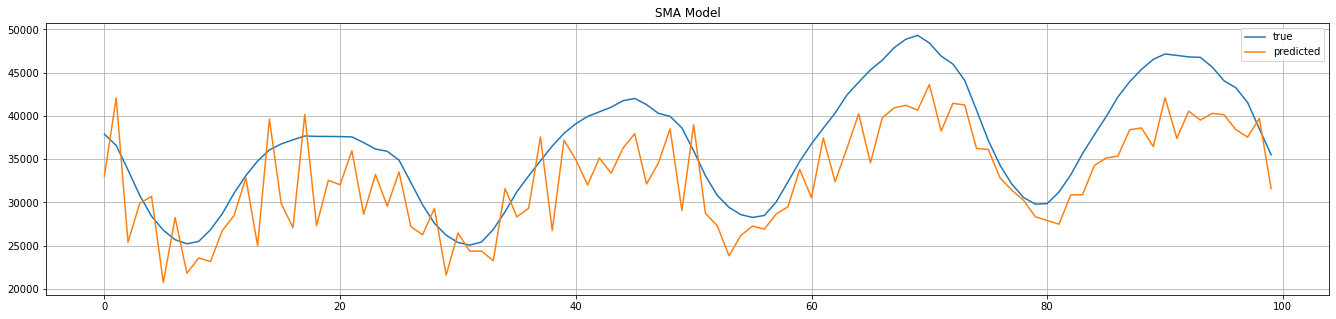

In [ ]:
sma_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
sma_model['True_value'] = test 
sma_model['Predicted_value'] = sma_predictions
print(sma_model.head())
########
print('*'*100)

rmse_sma,mae_sma,mape_sma,mse_sma = performance_metrics(sma_model.True_value,sma_model.Predicted_value)
print('RSME :',rmse_sma)
print('MAE :',mae_sma)
print('MAPE :',mape_sma)
print('MSE :',mse_sma)
###############

result_visualization(sma_model.True_value,sma_model.Predicted_value,title='SMA Model')

## SARMA Model

In [ ]:
%%time
sarma_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  sarma_model = SARIMAX(train,order=(3,0,1),seasonal_order=(3,0,1,24), enforce_stationarity=False, enfore_invertibility=False)
  sarma_model_fit = sarma_model.fit()
  sarma_pred = sarma_model_fit.forecast()
  sarma_predictions.append(sarma_pred[0])
  train.append(test[i])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:24:51<00:00, 50.91s/it]

Wall time: 1h 24min 51s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.536400
2018-07-29 22:00:00   10.507312        10.510176
2018-07-29 23:00:00   10.426676        10.434321
2018-07-30 00:00:00   10.334945        10.335482
2018-07-30 01:00:00   10.253792        10.249354
****************************************************************************************************
RSME : 291.88923566288383
MAE : 224.75202622615146
MAPE : 0.6058342616542538
MSE : 85199.32589586252


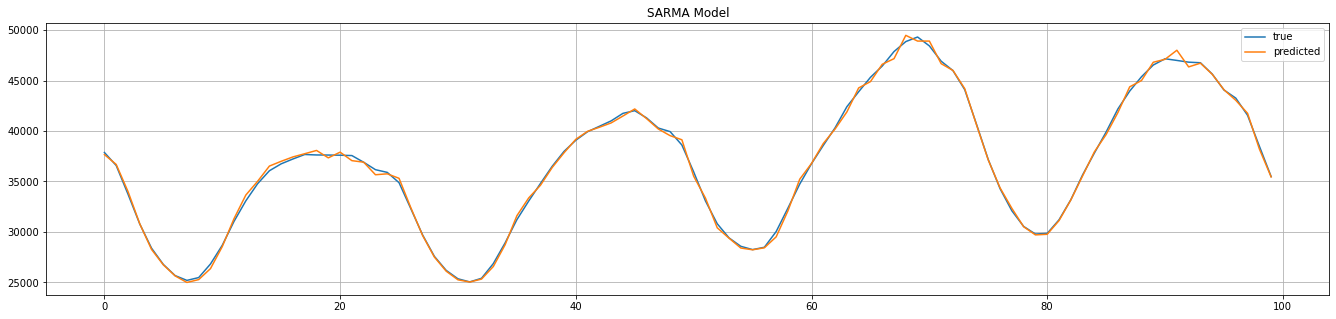

In [ ]:
sarma_model = pd.DataFrame(columns = ['True_value','Predicted_value'])
sarma_model['True_value'] = test 
sarma_model['Predicted_value'] = sarma_predictions
print(sarma_model.head())
########
print('*'*100)

rmse_sarma,mae_sarma,mape_sarma,mse_sarma = performance_metrics(sarma_model.True_value,sarma_model.Predicted_value)
print('RSME :',rmse_sarma)
print('MAE :',mae_sarma)
print('MAPE :',mape_sarma)
print('MSE :',mse_sarma)
###############

result_visualization(sarma_model.True_value,sarma_model.Predicted_value,title='SARMA Model')

## SARIMA Model

In [ ]:
%%time
sarima_predictions = []
train = [i for i in train]
for i in tqdm(range(len(test))):
  sarima_model = SARIMAX(train,order=(4,1,1),seasonal_order=(4,1,1,24), enforce_stationarity=False, enfore_invertibility=False)
  sarima_model_fit = sarima_model.fit()
  sarima_pred = sarima_model_fit.forecast()
  sarima_predictions.append(sarima_pred[0])
  train.append(test[i])

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:21:09<00:00, 84.69s/it]

Wall time: 2h 21min 9s


                     True_value  Predicted_value
Datetime                                        
2018-07-29 21:00:00   10.541941        10.536655
2018-07-29 22:00:00   10.507312        10.506017
2018-07-29 23:00:00   10.426676        10.437444
2018-07-30 00:00:00   10.334945        10.332850
2018-07-30 01:00:00   10.253792        10.250340
****************************************************************************************************
RSME : 275.51787614721525
MAE : 212.7680282500058
MAPE : 0.5627869085495087
MSE : 75910.10007667223


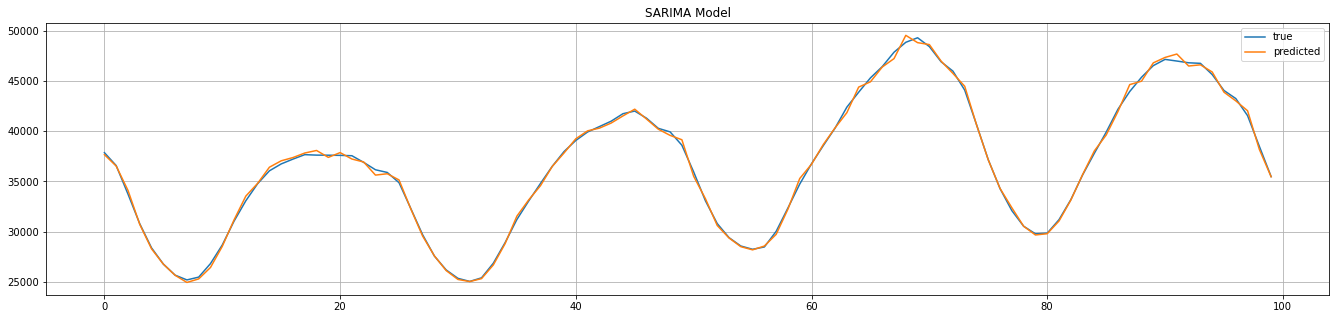

In [ ]:
sarima_model1 = pd.DataFrame(columns = ['True_value','Predicted_value'])
sarima_model1['True_value'] = test 
sarima_model1['Predicted_value'] = sarima_predictions
print(sarima_model1.head())
########
print('*'*100)

rmse_sarima1,mae_sarima1,mape_sarima1,mse_sarima1 = performance_metrics(sarima_model1.True_value,sarima_model1.Predicted_value)
print('RSME :',rmse_sarima1)
print('MAE :',mae_sarima1)
print('MAPE :',mape_sarima1)
print('MSE :',mse_sarima1)
###############

result_visualization(sarima_model1.True_value,sarima_model1.Predicted_value,title='SARIMA Model')

### Facebook Prophet Model

From site:

> Today Facebook is open sourcing Prophet, a forecasting tool available in Python and R. The idea is that producing high quality forecasts is not an easy problem for either machines or for most analysts. The models revolves around two main observations in the practice of creating a variety of business forecasts:
- Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
- Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

Prophet is an general additive model that includes a number of highly advanced, intelligent [forecasting methods](http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/), including [changepoint analysis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwjpwM_JhsbVAhWNxIMKHSWqD6kQFgguMAE&url=http%3A%2F%2Fwww.variation.com%2Fcpa%2Ftech%2Fchangepoint.html&usg=AFQjCNFK6wbwWuBCixZJHu03LkABXL3UHA):


_y = g(t) + s(t) + h(t) + $\epsilon_t$_

Here g(t) is the trend function which models non-periodic changes in the value of the time series,<br> s(t) represents periodic changes (e.g., weekly and yearly seasonality), and <br> h(t) represents the effects of holidays which occur on potentially irregular schedules over one or more days

- For trend, a piecewise linear or logistic growth curve trend is used. 
- Prophet automatically detects changes in trends by selecting changepoints from the data.
- For seasonalities, different seasonality components are modeled using Fourier series.
- One can either use fb provided list or incorporate their own holidays into model.

Prophet was originally optimized with the business forecast tasks encountered at Facebook in mind, which typically have any of the following characteristics:

- Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- Strong multiple “human-scale” seasonalities: day of week and time of year
- Important holidays that occur at irregular intervals that are known in advance
- A reasonable number of missing observations or large outliers
- Historical trend changes, for instance due to product launches or logging changes
- Trends that are non-linear growth curves, where a trend hits a natural limit or saturates




In [7]:
test_size = 100
df_tr = pjm_df_copy[:-test_size]#1191#5134 #-1000#-350
df_te = pjm_df_copy[-test_size:]
print('Type of df_train :',type(df_tr))
print('Type of df_tesy :',type(df_te))
print(df_tr.shape)
print(df_te.shape)

Type of df_train : <class 'pandas.core.frame.DataFrame'>
Type of df_tesy : <class 'pandas.core.frame.DataFrame'>
(145032, 6)
(100, 6)


In [8]:
df_tr = df_tr[['PJME_MW']]
df_te = df_te[['PJME_MW']]
df_tr = df_tr.reset_index()
df_tr = df_tr.rename(columns = {'Datetime':'ds','PJME_MW':'y'})
df_tr.head()

,ds,y
0,2002-01-08 03:00:00,10.253299
1,2002-01-08 04:00:00,10.259167
2,2002-01-08 05:00:00,10.284045
3,2002-01-08 06:00:00,10.352938
4,2002-01-08 07:00:00,10.472658


In [9]:
model_prophet = Prophet(daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True)
model_prophet.fit(df_tr)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [10]:
prophet_forecast_model = model_prophet.predict(df = df_te.reset_index().rename(columns={'Datetime':'ds'}))
prophet_forecast_model.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-07-29 21:00:00,10.318395,10.425529,10.687122,10.318395,10.318395,0.237856,0.237856,0.237856,0.117447,0.117447,0.117447,-0.052263,-0.052263,-0.052263,0.172673,0.172673,0.172673,0.0,0.0,0.0,10.556251
1,2018-07-29 22:00:00,10.318394,10.372709,10.635679,10.318394,10.318394,0.196229,0.196229,0.196229,0.070987,0.070987,0.070987,-0.047325,-0.047325,-0.047325,0.172567,0.172567,0.172567,0.0,0.0,0.0,10.514624
2,2018-07-29 23:00:00,10.318394,10.322630,10.586368,10.318394,10.318394,0.135254,0.135254,0.135254,0.005113,0.005113,0.005113,-0.042319,-0.042319,-0.042319,0.172460,0.172460,0.172460,0.0,0.0,0.0,10.453648
3,2018-07-30 00:00:00,10.318393,10.244139,10.513037,10.318393,10.318393,0.067242,0.067242,0.067242,-0.067835,-0.067835,-0.067835,-0.037276,-0.037276,-0.037276,0.172353,0.172353,0.172353,0.0,0.0,0.0,10.385635
4,2018-07-30 01:00:00,10.318392,10.191513,10.449946,10.318392,10.318392,0.004274,0.004274,0.004274,-0.135747,-0.135747,-0.135747,-0.032225,-0.032225,-0.032225,0.172246,0.172246,0.172246,0.0,0.0,0.0,10.322666


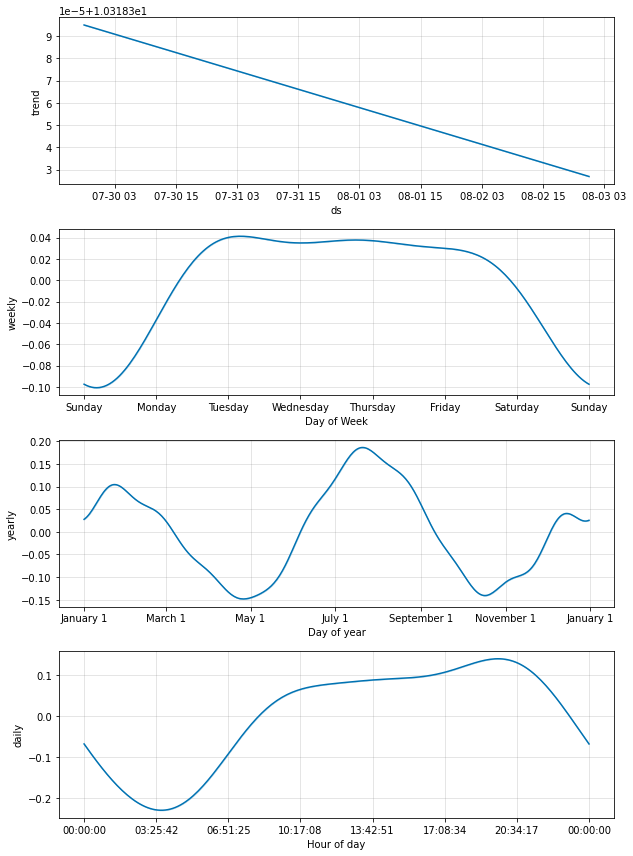

In [13]:
# Plot the components of the model
prophet_model_plots = model_prophet.plot_components(prophet_forecast_model)

RSME : 3668.407160083357
MAE : 3068.529063834459
MAPE : 8.545987114406264
MSE : 13457211.09215084


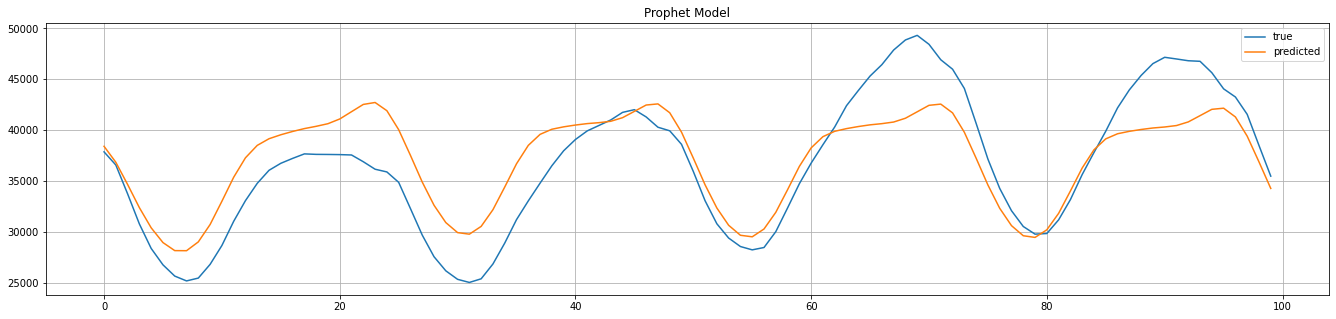

In [11]:
rmse_pr,mae_pr,mape_pr,mse_pr = performance_metrics(df_te['PJME_MW'],prophet_forecast_model['yhat'])
print('RSME :',rmse_pr)
print('MAE :',mae_pr)
print('MAPE :',mape_pr)
print('MSE :',mse_pr)

result_visualization(df_te['PJME_MW'],prophet_forecast_model['yhat'],title='Prophet Model')

# Multivariate Time Series Analysis

## Machine Learning Modelling

### Train-Test Time Based Split

In [ ]:
test_size_ml =100 #43540
df_train_ml = pjm_df_copy[:-test_size_ml]
df_test_ml = pjm_df_copy[-test_size_ml:]
print('Type of df_train :',type(df_train_ml))
print('Type of df_tesy :',type(df_test_ml))
print(df_train_ml.shape)
print(df_test_ml.shape)

Type of df_train : <class 'pandas.core.frame.DataFrame'>
Type of df_tesy : <class 'pandas.core.frame.DataFrame'>
(145032, 6)
(100, 6)


In [ ]:
print('Indexes of training data \n')
print(df_train_ml.index)

print('*'*100)

print('Indexes of test data \n')
print(df_test_ml.index)

Indexes of training data 

DatetimeIndex(['2002-01-08 03:00:00', '2002-01-08 04:00:00',
               '2002-01-08 05:00:00', '2002-01-08 06:00:00',
               '2002-01-08 07:00:00', '2002-01-08 08:00:00',
               '2002-01-08 09:00:00', '2002-01-08 10:00:00',
               '2002-01-08 11:00:00', '2002-01-08 12:00:00',
               ...
               '2018-07-29 11:00:00', '2018-07-29 12:00:00',
               '2018-07-29 13:00:00', '2018-07-29 14:00:00',
               '2018-07-29 15:00:00', '2018-07-29 16:00:00',
               '2018-07-29 17:00:00', '2018-07-29 18:00:00',
               '2018-07-29 19:00:00', '2018-07-29 20:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145032, freq=None)
****************************************************************************************************
Indexes of test data 

DatetimeIndex(['2018-07-29 21:00:00', '2018-07-29 22:00:00',
               '2018-07-29 23:00:00', '2018-07-30 00:00:00',
               '

In [ ]:
df_train_ml = df_train_ml.reset_index()
df_test_ml = df_test_ml.reset_index()

print('Training data \n')
print(df_train_ml.head())

print('*'*100)

print('Test data \n')
print(df_test_ml.head())

Training data 

             Datetime    PJME_MW  ...  hour_sin_feature  rolling_day_mean
0 2002-01-08 03:00:00  10.253299  ...          0.707107          0.429240
1 2002-01-08 04:00:00  10.259167  ...          0.866025          0.432506
2 2002-01-08 05:00:00  10.284045  ...          0.965926          0.435912
3 2002-01-08 06:00:00  10.352938  ...          1.000000          0.439369
4 2002-01-08 07:00:00  10.472658  ...          0.965926          0.443005

[5 rows x 7 columns]
****************************************************************************************************
Test data 

             Datetime    PJME_MW  ...  hour_sin_feature  rolling_day_mean
0 2018-07-29 21:00:00  10.541941  ...         -0.707107          0.397437
1 2018-07-29 22:00:00  10.507312  ...         -0.500000          0.395341
2 2018-07-29 23:00:00  10.426676  ...         -0.258819          0.393560
3 2018-07-30 00:00:00  10.334945  ...          0.000000          0.392297
4 2018-07-30 01:00:00  10.253792  .

In [ ]:
X_train = df_train_ml.drop(['PJME_MW','Datetime'],axis=1).values
X_test = df_test_ml.drop(['PJME_MW','Datetime'],axis=1).values
y_train = df_train_ml['PJME_MW'].values
y_test = df_test_ml['PJME_MW'].values
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Dummy Regressor

In [ ]:
%%time
dummy_model = DummyRegressor(strategy="quantile",quantile=0.8)
dummy_model.fit(X_train, y_train)
dummy_model_predict = dummy_model.predict(X_test)

Wall time: 3.99 ms


RSME : 6632.97201411253
MAE : 5486.560000000003
MAPE : 15.984502687436617
MSE : 43996317.74000003


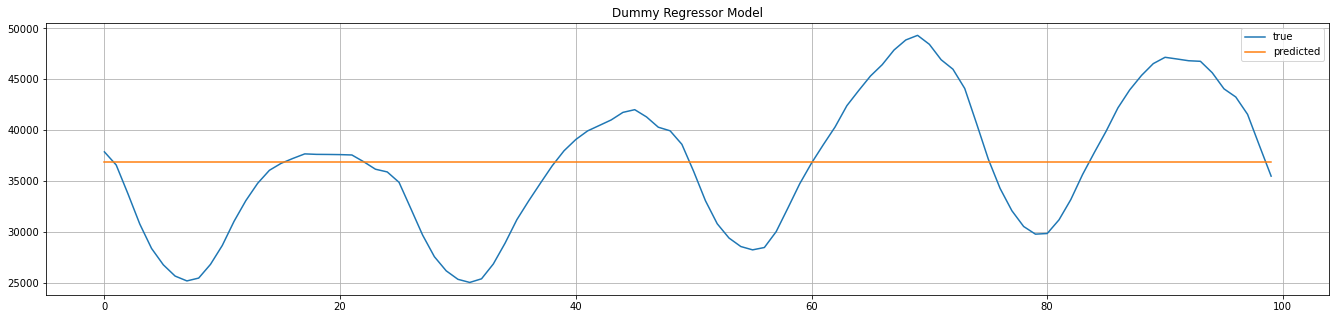

In [ ]:
rmse_dummy,mae_dummy,mape_dummy,mse_dummy = performance_metrics(y_test,dummy_model_predict)
print('RSME :',rmse_dummy)
print('MAE :',mae_dummy)
print('MAPE :',mape_dummy)
print('MSE :',mse_dummy)

result_visualization(y_test,dummy_model_predict,title='Dummy Regressor Model')

### SVR

In [ ]:


parameters = {'C':[100,300,500,750,1000,2000,5000,10000],
             'gamma':['auto','scale'],
             'kernel':['rbf','linear','poly']}

svr_reg = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                      n_jobs=-1,cv=3)
svr_reg.fit(X_train,y_train)
print("best parameters found was :",svr_reg.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best parameters found was : {'C': 5000, 'gamma': 'scale'}


In [ ]:
%%time
svr_model = SVR(C=5000,gamma='scale',kernel='rbf')
svr_model.fit(X_train,y_train)
svr_prediction = svr_model.predict(X_test)

Wall time: 6.59 s


RSME : 1083.289927038073
MAE : 857.4325063923665
MAPE : 2.362513535111038
MSE : 1173517.0660221537


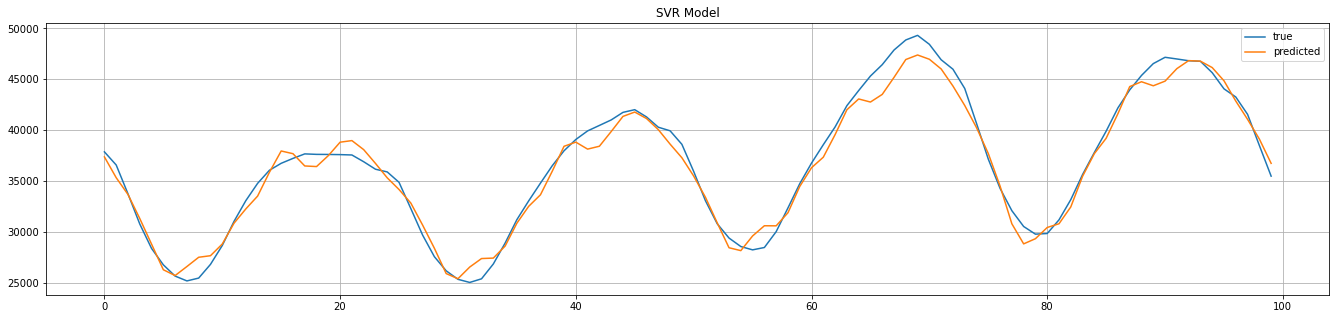

In [ ]:
rmse_svr,mae_svr,mape_svr,mse_svr = performance_metrics(y_test,svr_prediction)
print('RSME :',rmse_svr)
print('MAE :',mae_svr)
print('MAPE :',mape_svr)
print('MSE :',mse_svr)

result_visualization(y_test,svr_prediction,title='SVR Model')

### LightGBM

In [ ]:
%%time

parameters = {"n_estimators":[10,50,250,500,750,1000,1250],
             "max_depth":[2,3,4,5],
             "learning_rate":[0.1,0.01,0.001]}

reg = GridSearchCV(lightgbm.LGBMRegressor(),param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                   n_jobs=-1, cv=3)

reg.fit(X_train,y_train)
print("best parameters found was :",reg.best_params_)


Fitting 3 folds for each of 84 candidates, totalling 252 fits
best parameters found was : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1250}
Wall time: 13min 27s


In [ ]:
%%time
lgbm_reg = lightgbm.LGBMRegressor(n_estimators=500,max_depth=3,learning_rate =0.01,n_jobs=-1)
                                
lgbm_reg.fit(X_train,y_train)
lgbm_prediction = lgbm_reg.predict(X_test)

Wall time: 1.41 s


RSME : 686.9715947449769
MAE : 534.3118803956382
MAPE : 1.4315156413767056
MSE : 471929.97198645666


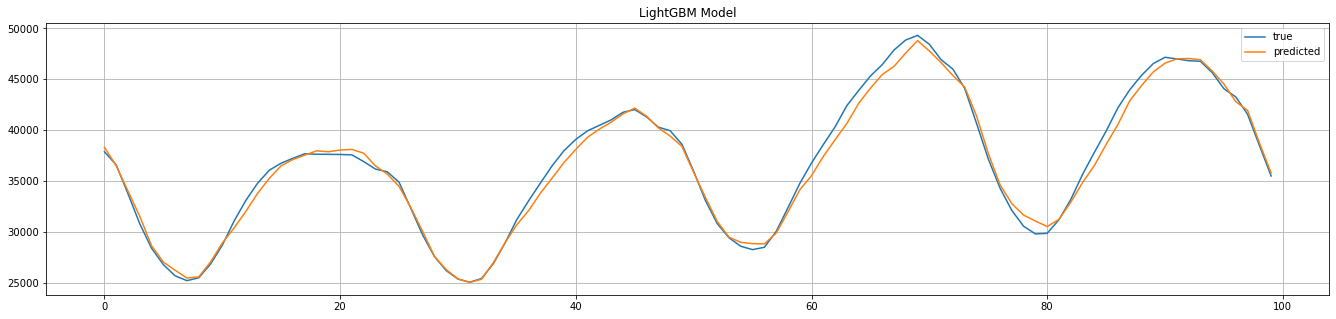

In [ ]:
rmse_lgbm,mae_lgbm,mape_lgbm,mse_lgbm = performance_metrics(y_test,lgbm_prediction)
print('RSME :',rmse_lgbm)
print('MAE :',mae_lgbm)
print('MAPE :',mape_lgbm)
print('MSE :',mse_lgbm)

result_visualization(y_test,lgbm_prediction,title='LightGBM Model')

### SGD Linear Regression

In [ ]:
%%time

parameters = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100],
             'max_iter':[100,300,500,1000,2000],
             'penalty':['l1','l2','elasticnet'],
             'loss':['squared_epsilon_insensitive']}

lin_reg = GridSearchCV(SGDRegressor(),param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                   n_jobs=-1, cv=3)
lin_reg.fit(X_train,y_train)
print("best parameters found was :",lin_reg.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
best parameters found was : {'alpha': 0.001, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'penalty': 'l1'}
Wall time: 35.3 s


In [ ]:
%%time
sgd_lin_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.001,penalty='l1',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
sgd_lin_reg.fit(X_train,y_train)
sgd_lin_prediction = sgd_lin_reg.predict(X_test)

Wall time: 958 ms


RSME : 989.4021907036985
MAE : 873.3235155087086
MAPE : 2.4115372373963857
MSE : 978916.6949692777


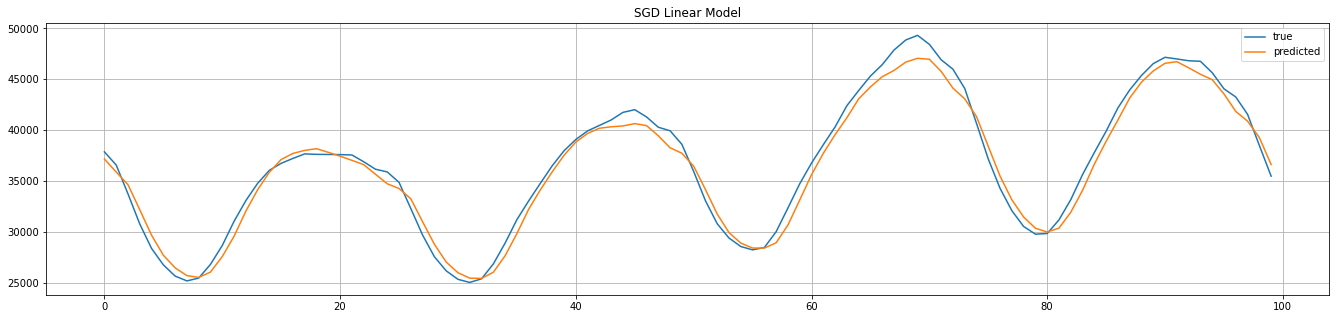

In [ ]:
rmse_sgd,mae_sgd,mape_sgd,mse_sgd = performance_metrics(y_test,sgd_lin_prediction)
print('RSME :',rmse_sgd)
print('MAE :',mae_sgd)
print('MAPE :',mape_sgd)
print('MSE :',mse_sgd)

result_visualization(y_test,sgd_lin_prediction,title='SGD Linear Model')

### Random Forest

In [ ]:
%%time

parameters = {"n_estimators":[100,250,500,750,1000,1250],
             "max_depth":[3,5,10,50],
             "max_features":['auto','sqrt','log2']}

rf_reg = GridSearchCV(RandomForestRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
rf_reg.fit(X_train,y_train)
print("best parameters found was :",rf_reg.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
best parameters found was : {'max_depth': 50, 'max_features': 'auto', 'n_estimators': 1250}
Wall time: 4h 23s


In [ ]:
%%time
random_fst_model = RandomForestRegressor(n_estimators=1250,n_jobs=-1,bootstrap=True,max_depth=50,max_features='auto',
                           verbose=5,random_state=1)
random_fst_model.fit(X_train,y_train)
random_fst_prediction = random_fst_model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1250building tree 2 of 1250
building tree 3 of 1250
building tree 4 of 1250

building tree 5 of 1250
building tree 6 of 1250
building tree 7 of 1250
building tree 8 of 1250
building tree 9 of 1250
building tree 10 of 1250
building tree 11 of 1250
building tree 12 of 1250
building tree 13 of 1250
building tree 14 of 1250
building tree 15 of 1250
building tree 16 of 1250


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 17 of 1250
building tree 18 of 1250
building tree 19 of 1250
building tree 20 of 1250
building tree 21 of 1250
building tree 22 of 1250
building tree 23 of 1250
building tree 24 of 1250
building tree 25 of 1250
building tree 26 of 1250
building tree 27 of 1250
building tree 28 of 1250
building tree 29 of 1250
building tree 30 of 1250
building tree 31 of 1250
building tree 32 of 1250
building tree 33 of 1250
building tree 34 of 1250
building tree 35 of 1250
building tree 36 of 1250
building tree 37 of 1250
building tree 38 of 1250
building tree 39 of 1250
building tree 40 of 1250
building tree 41 of 1250
building tree 42 of 1250
building tree 43 of 1250
building tree 44 of 1250
building tree 45 of 1250
building tree 46 of 1250
building tree 47 of 1250
building tree 48 of 1250
building tree 49 of 1250
building tree 50 of 1250
building tree 51 of 1250
building tree 52 of 1250
building tree 53 of 1250
building tree 54 of 1250
building tree 55 of 1250
building tree 56 of 1250


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.1s


building tree 69 of 1250
building tree 70 of 1250
building tree 71 of 1250
building tree 72 of 1250
building tree 73 of 1250
building tree 74 of 1250
building tree 75 of 1250
building tree 76 of 1250
building tree 77 of 1250
building tree 78 of 1250
building tree 79 of 1250
building tree 80 of 1250
building tree 81 of 1250
building tree 82 of 1250
building tree 83 of 1250
building tree 84 of 1250
building tree 85 of 1250
building tree 86 of 1250
building tree 87 of 1250
building tree 88 of 1250
building tree 89 of 1250
building tree 90 of 1250
building tree 91 of 1250
building tree 92 of 1250
building tree 93 of 1250
building tree 94 of 1250
building tree 95 of 1250
building tree 96 of 1250
building tree 97 of 1250
building tree 98 of 1250
building tree 99 of 1250
building tree 100 of 1250
building tree 101 of 1250
building tree 102 of 1250
building tree 103 of 1250
building tree 104 of 1250
building tree 105 of 1250
building tree 106 of 1250
building tree 107 of 1250
building tree 108

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   40.9s


building tree 161 of 1250
building tree 162 of 1250
building tree 163 of 1250
building tree 164 of 1250
building tree 165 of 1250
building tree 166 of 1250
building tree 167 of 1250
building tree 168 of 1250
building tree 169 of 1250
building tree 170 of 1250
building tree 171 of 1250
building tree 172 of 1250
building tree 173 of 1250
building tree 174 of 1250
building tree 175 of 1250
building tree 176 of 1250
building tree 177 of 1250
building tree 178 of 1250
building tree 179 of 1250
building tree 180 of 1250
building tree 181 of 1250
building tree 182 of 1250
building tree 183 of 1250
building tree 184 of 1250
building tree 185 of 1250
building tree 186 of 1250
building tree 187 of 1250
building tree 188 of 1250
building tree 189 of 1250
building tree 190 of 1250
building tree 191 of 1250
building tree 192 of 1250
building tree 193 of 1250
building tree 194 of 1250
building tree 195 of 1250
building tree 196 of 1250
building tree 197 of 1250
building tree 198 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


building tree 285 of 1250
building tree 286 of 1250
building tree 287 of 1250
building tree 288 of 1250
building tree 289 of 1250
building tree 290 of 1250
building tree 291 of 1250
building tree 292 of 1250
building tree 293 of 1250
building tree 294 of 1250
building tree 295 of 1250
building tree 296 of 1250
building tree 297 of 1250
building tree 298 of 1250
building tree 299 of 1250
building tree 300 of 1250
building tree 301 of 1250
building tree 302 of 1250
building tree 303 of 1250
building tree 304 of 1250
building tree 305 of 1250
building tree 306 of 1250
building tree 307 of 1250
building tree 308 of 1250
building tree 309 of 1250
building tree 310 of 1250
building tree 311 of 1250
building tree 312 of 1250
building tree 313 of 1250
building tree 314 of 1250
building tree 315 of 1250
building tree 316 of 1250
building tree 317 of 1250
building tree 318 of 1250
building tree 319 of 1250
building tree 320 of 1250
building tree 321 of 1250
building tree 322 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min



building tree 448 of 1250
building tree 449 of 1250
building tree 450 of 1250
building tree 451 of 1250
building tree 452 of 1250
building tree 453 of 1250
building tree 454 of 1250
building tree 455 of 1250
building tree 456 of 1250
building tree 457 of 1250
building tree 458 of 1250
building tree 459 of 1250
building tree 460 of 1250
building tree 461 of 1250
building tree 462 of 1250
building tree 463 of 1250
building tree 464 of 1250
building tree 465 of 1250
building tree 466 of 1250
building tree 467 of 1250
building tree 468 of 1250
building tree 469 of 1250
building tree 470 of 1250
building tree 471 of 1250
building tree 472 of 1250
building tree 473 of 1250
building tree 474 of 1250
building tree 475 of 1250
building tree 476 of 1250
building tree 477 of 1250
building tree 478 of 1250
building tree 479 of 1250
building tree 480 of 1250
building tree 481 of 1250
building tree 482 of 1250
building tree 483 of 1250
building tree 484 of 1250
building tree 485 of 1250
building tr

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min


building tree 645 of 1250
building tree 646 of 1250
building tree 647 of 1250
building tree 648 of 1250
building tree 649 of 1250
building tree 650 of 1250
building tree 651 of 1250
building tree 652 of 1250
building tree 653 of 1250
building tree 654 of 1250
building tree 655 of 1250
building tree 656 of 1250
building tree 657 of 1250
building tree 658 of 1250
building tree 659 of 1250
building tree 660 of 1250
building tree 661 of 1250
building tree 662 of 1250
building tree 663 of 1250
building tree 664 of 1250
building tree 665 of 1250
building tree 666 of 1250
building tree 667 of 1250
building tree 668 of 1250
building tree 669 of 1250
building tree 670 of 1250
building tree 671 of 1250
building tree 672 of 1250
building tree 673 of 1250
building tree 674 of 1250
building tree 675 of 1250
building tree 676 of 1250
building tree 677 of 1250
building tree 678 of 1250
building tree 679 of 1250
building tree 680 of 1250
building tree 681 of 1250
building tree 682 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.9min


building tree 879 of 1250
building tree 880 of 1250
building tree 881 of 1250
building tree 882 of 1250
building tree 883 of 1250
building tree 884 of 1250
building tree 885 of 1250
building tree 886 of 1250
building tree 887 of 1250
building tree 888 of 1250
building tree 889 of 1250
building tree 890 of 1250
building tree 891 of 1250
building tree 892 of 1250
building tree 893 of 1250
building tree 894 of 1250
building tree 895 of 1250
building tree 896 of 1250
building tree 897 of 1250
building tree 898 of 1250
building tree 899 of 1250
building tree 900 of 1250
building tree 901 of 1250
building tree 902 of 1250
building tree 903 of 1250
building tree 904 of 1250
building tree 905 of 1250
building tree 906 of 1250
building tree 907 of 1250
building tree 908 of 1250
building tree 909 of 1250
building tree 910 of 1250
building tree 911 of 1250
building tree 912 of 1250
building tree 913 of 1250
building tree 914 of 1250
building tree 915 of 1250
building tree 916 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  5.2min


building tree 1152 of 1250
building tree 1153 of 1250
building tree 1154 of 1250
building tree 1155 of 1250
building tree 1156 of 1250
building tree 1157 of 1250
building tree 1158 of 1250
building tree 1159 of 1250
building tree 1160 of 1250
building tree 1161 of 1250
building tree 1162 of 1250
building tree 1163 of 1250
building tree 1164 of 1250
building tree 1165 of 1250
building tree 1166 of 1250
building tree 1167 of 1250
building tree 1168 of 1250
building tree 1169 of 1250
building tree 1170 of 1250
building tree 1171 of 1250
building tree 1172 of 1250
building tree 1173 of 1250
building tree 1174 of 1250
building tree 1175 of 1250
building tree 1176 of 1250
building tree 1177 of 1250building tree 1178 of 1250

building tree 1179 of 1250
building tree 1180 of 1250
building tree 1181 of 1250
building tree 1182 of 1250
building tree 1183 of 1250
building tree 1184 of 1250
building tree 1185 of 1250
building tree 1186 of 1250
building tree 1187 of 1250
building tree 1188 of 1250
b

[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  5.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:   14.3s finished


Wall time: 5min 59s


RSME : 274.8719803206898
MAE : 198.22793642411406
MAPE : 0.5391630866418604
MSE : 75554.60556541766


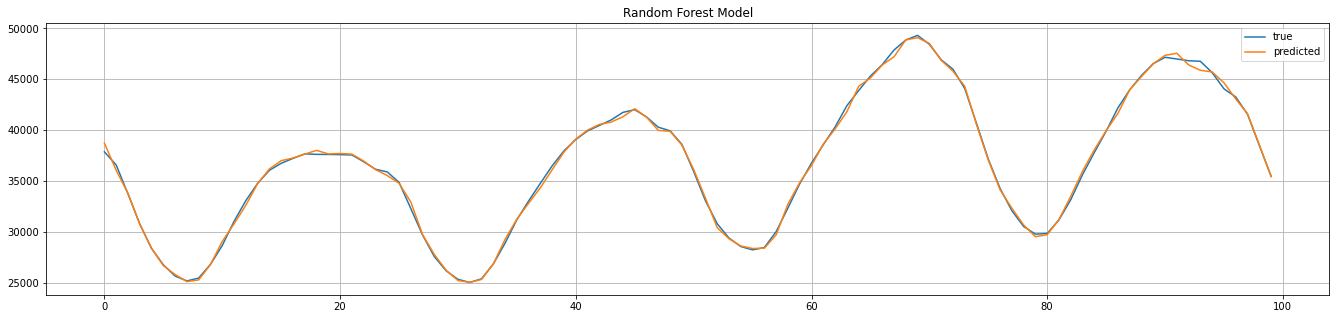

In [ ]:
rmse_random,mae_random,mape_random,mse_random = performance_metrics(y_test,random_fst_prediction)
print('RSME :',rmse_random)
print('MAE :',mae_random)
print('MAPE :',mape_random)
print('MSE :',mse_random)

result_visualization(y_test,random_fst_prediction,title='Random Forest Model')

## Decision Tree Model

In [ ]:
%%time


parameters = {'max_depth': [2, 5, 15, 25, 50, 75, 100],
                                 'min_samples_split': [2, 3, 5, 7, 10],
                                 'min_samples_leaf': [1, 3, 5],
                                 'max_features': ['auto', 'sqrt', 'log2']}
dt_reg = GridSearchCV(DecisionTreeRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
dt_reg.fit(X_train,y_train)
print("best parameters found was :",dt_reg.best_params_)

Fitting 3 folds for each of 315 candidates, totalling 945 fits
best parameters found was : {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5}
Wall time: 3min 13s


In [ ]:
%%time
decision_tree_model = DecisionTreeRegressor(max_depth=50,max_features='auto',min_samples_leaf=5,
                                            min_samples_split =5,random_state=1)
decision_tree_model.fit(X_train,y_train)
decision_tree_prediction = decision_tree_model.predict(X_test)

Wall time: 884 ms


RSME : 376.42827764352637
MAE : 287.0508441790374
MAPE : 0.7894368604348522
MSE : 141698.24820967176


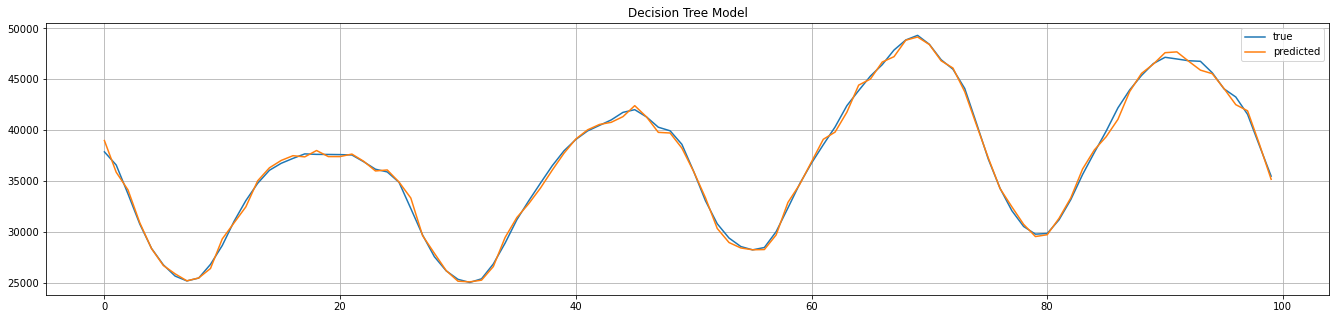

In [ ]:
rmse_decision,mae_decision,mape_decision,mse_decision = performance_metrics(y_test,decision_tree_prediction)
print('RSME :',rmse_decision)
print('MAE :',mae_decision)
print('MAPE :',mape_decision)
print('MSE :',mse_decision)

result_visualization(y_test,decision_tree_prediction,title='Decision Tree Model')

## K_Nearest Neighbor Model

In [ ]:
%%time


parameters = {'n_neighbors':[5,10,20,30,40,50,60,70,80,90,100],
             'weights':['uniform','distance']}

knn_reg = GridSearchCV(KNeighborsRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
knn_reg.fit(X_train,y_train)
print("best parameters found was :",knn_reg.best_params_)

Fitting 3 folds for each of 22 candidates, totalling 66 fits
best parameters found was : {'n_neighbors': 5, 'weights': 'distance'}
Wall time: 1min 45s


In [ ]:
%%time
knn_model = KNeighborsRegressor(n_neighbors=5,weights='distance')
knn_model.fit(X_train,y_train)
knn_prediction = knn_model.predict(X_test)

Wall time: 827 ms


RSME : 360.8944865859538
MAE : 292.3565624275302
MAPE : 0.7997457348491386
MSE : 130244.8304481392


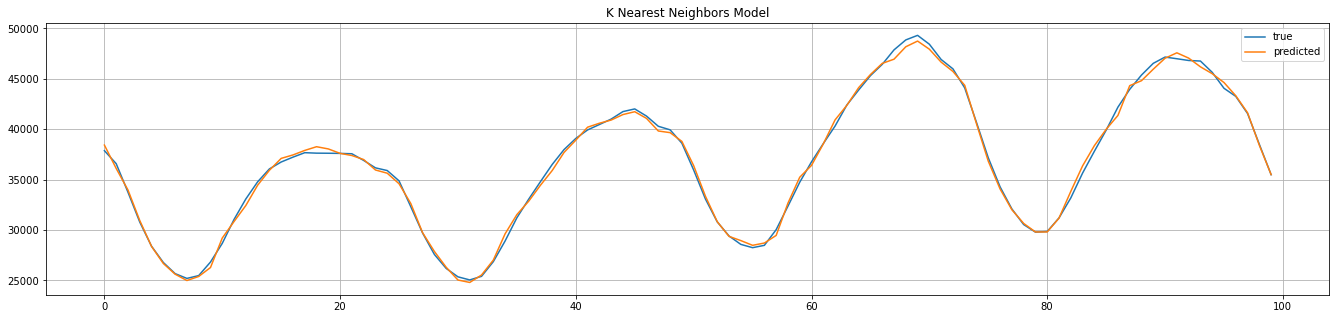

In [ ]:
rmse_knn,mae_knn,mape_knn,mse_knn = performance_metrics(y_test,knn_prediction)
print('RSME :',rmse_knn)
print('MAE :',mae_knn)
print('MAPE :',mape_knn)
print('MSE :',mse_knn)

result_visualization(y_test,knn_prediction,title='K Nearest Neighbors Model')

# Deep learning Model

In [ ]:
#reshaping the training and test data to 3D tensor
X_tr = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_te = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#X_te = X_test.copy()
#reshaping the training and test data to 2D tensor
y_tr = y_train.reshape((y_train.shape[0],1))
y_te = y_test.reshape((y_test.shape[0],1))

print('Shape of X_train data after reshaping to 3D arrays :',X_tr.shape)
print('Shape of X_test data after reshaping to 3D arrays :',X_te.shape)
print('Rechecking the type of X_training data :',type(X_tr))
print('Rechecking the type of X_test data :',type(X_te))

print('Shape of y_train data after reshaping to 3D arrays :',y_tr.shape)
print('Shape of y_test data after reshaping to 3D arrays :',y_te.shape)
print('Rechecking the type of y_training data :',type(y_tr))
print('Rechecking the type of y_test data :',type(y_te))

Shape of X_train data after reshaping to 3D arrays : (145032, 5, 1)
Shape of X_test data after reshaping to 3D arrays : (100, 5, 1)
Rechecking the type of X_training data : <class 'numpy.ndarray'>
Rechecking the type of X_test data : <class 'numpy.ndarray'>
Shape of y_train data after reshaping to 3D arrays : (145032, 1)
Shape of y_test data after reshaping to 3D arrays : (100, 1)
Rechecking the type of y_training data : <class 'numpy.ndarray'>
Rechecking the type of y_test data : <class 'numpy.ndarray'>


## LSTM

In [ ]:
tf.keras.backend.clear_session()  # For easy reset of notebook state
input_layer = Input(shape = (5,1),name = 'input_layer')
lstm_layer_1 = LSTM(500, return_sequences=True,activation='relu',name='lstm_layer_1')(input_layer)
dropout_layer_1 = Dropout(0.25,name='dropout_layer_1')(lstm_layer_1)
lstm_layer_2 = LSTM(600, return_sequences=True,activation='relu',name='lstm_layer_2')(dropout_layer_1)
dropout_layer_2 = Dropout(0.25,name='dropout_layer_2')(lstm_layer_2)
output_layer = Dense(1,name='output_layer')(dropout_layer_2)

lstm_model=Model(inputs=input_layer,outputs=output_layer)
opt = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
lstm_rmse = tf.keras.metrics.RootMeanSquaredError()
lstm_mape = tf.keras.metrics.MeanAbsolutePercentageError()
lstm_model.compile(optimizer=opt, loss='log_cosh',metrics=[lstm_rmse,lstm_mape])
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 1)]            0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 5, 500)            1004000   
                                                                 
 dropout_layer_1 (Dropout)   (None, 5, 500)            0         
                                                                 
 lstm_layer_2 (LSTM)         (None, 5, 600)            2642400   
                                                                 
 dropout_layer_2 (Dropout)   (None, 5, 600)            0         
                                                                 
 output_layer (Dense)        (None, 5, 1)              601       
                                                                 
Total params: 3,647,001
Trainable params: 3,647,001
Non-train

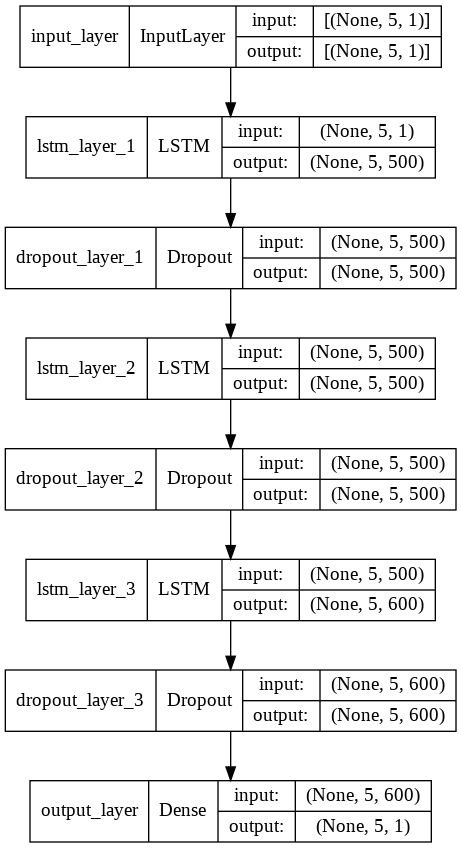

In [ ]:
plot_model(lstm_model,show_shapes=True)

In [ ]:
#callbacks
#check_pt = ModelCheckpoint('/content/gdrive/MyDrive/Case Study 1/lstm_model.hdf5', monitor = 'root_mean_squared_error')
lstm_earlystopping = EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=10,verbose=1,mode='min')

def Learning_Rate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lstm_lr_scheduler = LearningRateScheduler(Learning_Rate, verbose=1)

lstm_reduced_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=5,verbose=1,mode='min')

In [ ]:
batch_size = 512*3
epochs = 500
#lstm_model.fit(X_tr,y_train,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[check_pt],validation_data=(X_te, y_test))
#lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[reduce_lr,lrschedule,lstm_earlystopping],validation_data=(X_te, y_te))
lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[lstm_reduced_lr,lstm_lr_scheduler,lstm_earlystopping])




Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
95/95 - 19s - loss: 0.0821 - root_mean_squared_error: 0.4214 - mean_absolute_percentage_error: 3.2292 - lr: 0.0010 - 19s/epoch - 203ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
95/95 - 19s - loss: 0.0767 - root_mean_squared_error: 0.4062 - mean_absolute_percentage_error: 3.1190 - lr: 0.0010 - 19s/epoch - 201ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
95/95 - 19s - loss: 0.0734 - root_mean_squared_error: 0.3967 - mean_absolute_percentage_error: 3.0521 - lr: 0.0010 - 19s/epoch - 201ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
95/95 - 19s - loss: 0.0715 - root_mean_squared_error: 0.3909 - mean_absolute_percentage_error: 3.0092 - lr: 0.0010 - 19s/epoch - 201ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.000980000

In [ ]:
y_lstm_predictions = lstm_model.predict(X_te)
print(type(y_lstm_predictions))
print(y_lstm_predictions.shape)


<class 'numpy.ndarray'>
(100, 5, 1)


In [ ]:
#https://github.com/PacktPublishing/Practical-Time-Series-Analysis/blob/master/Chapter05/Chapter_5_PM2.5_Time_Series_Forecasting_by_LSTM.ipynb

(100,)

RSME : 323.64155101771155
MAE : 258.9083984375003
MAPE : 21.656026792207488
MSE : 104743.85354514998


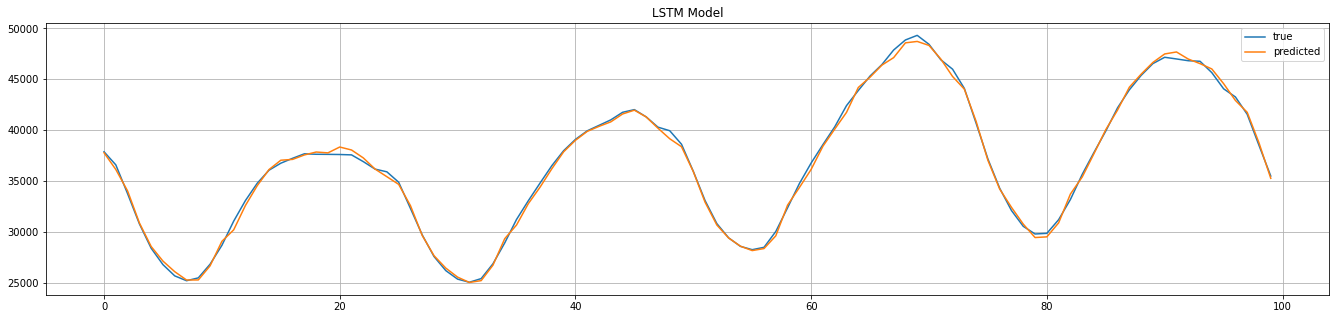

In [ ]:
y_predicted = [x[4] for x in y_lstm_predictions]
rmse_lstm,mae_lstm,mape_lstm,mse_lstm = performance_metrics(y_te,y_predicted)
print('RSME :',rmse_lstm)
print('MAE :',mae_lstm)
print('MAPE :',mape_lstm)
print('MSE :',mse_lstm)

result_visualization(y_te,y_predicted,title='LSTM Model')

## Bidirectional LSTM Model

In [ ]:
tf.keras.backend.clear_session()  # For easy reset of notebook state
input_layer = Input(shape = (5,1),name = 'input_layer')
lstm_layer_1 = Bidirectional(LSTM(500, return_sequences=True,activation='relu'),name='lstm_layer_1')(input_layer)
dropout_layer_1 = Dropout(0.25,name='dropout_layer_1')(lstm_layer_1)
lstm_layer_2 = Bidirectional(LSTM(550, return_sequences=True,activation='relu'),name='lstm_layer_2')(dropout_layer_1)
dropout_layer_2 = Dropout(0.3,name='dropout_layer_2')(lstm_layer_2)
output_layer = Dense(1,name='output_layer')(dropout_layer_2)

bi_lstm_model=Model(inputs=input_layer,outputs=output_layer)
opt = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
lstm_rmse = tf.keras.metrics.RootMeanSquaredError()
lstm_mape = tf.keras.metrics.MeanAbsolutePercentageError()
bi_lstm_model.compile(optimizer=opt, loss='log_cosh',metrics=[lstm_rmse,lstm_mape])
bi_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 1)]            0         
                                                                 
 lstm_layer_1 (Bidirectional  (None, 5, 1000)          2008000   
 )                                                               
                                                                 
 dropout_layer_1 (Dropout)   (None, 5, 1000)           0         
                                                                 
 lstm_layer_2 (Bidirectional  (None, 5, 1100)          6824400   
 )                                                               
                                                                 
 dropout_layer_2 (Dropout)   (None, 5, 1100)           0         
                                                                 
 output_layer (Dense)        (None, 5, 1)              1101  

In [ ]:
#callbacks
#check_pt = ModelCheckpoint('/content/gdrive/MyDrive/Case Study 1/lstm_model.hdf5', monitor = 'root_mean_squared_error')
lstm_earlystopping = EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=10,verbose=1,mode='min')

def Learning_Rate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lstm_lr_scheduler = LearningRateScheduler(Learning_Rate, verbose=1)

lstm_reduced_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=5,verbose=1,mode='min')

In [ ]:
batch_size = 512*3
epochs = 300
#lstm_model.fit(X_tr,y_train,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[check_pt],validation_data=(X_te, y_test))
#lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[reduce_lr,lrschedule,lstm_earlystopping],validation_data=(X_te, y_te))
bi_lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[lstm_reduced_lr,lstm_lr_scheduler,lstm_earlystopping])




Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
95/95 - 28s - loss: 0.0446 - root_mean_squared_error: 0.3049 - mean_absolute_percentage_error: 2.3502 - lr: 0.0010 - 28s/epoch - 300ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/300
95/95 - 28s - loss: 0.0438 - root_mean_squared_error: 0.3023 - mean_absolute_percentage_error: 2.3279 - lr: 0.0010 - 28s/epoch - 299ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/300
95/95 - 28s - loss: 0.0432 - root_mean_squared_error: 0.3002 - mean_absolute_percentage_error: 2.3133 - lr: 0.0010 - 28s/epoch - 299ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/300
95/95 - 28s - loss: 0.0439 - root_mean_squared_error: 0.3027 - mean_absolute_percentage_error: 2.3318 - lr: 0.0010 - 28s/epoch - 299ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.000980000

In [ ]:
y_bi_lstm_predictions = bi_lstm_model.predict(X_te)
print(type(y_bi_lstm_predictions))
print(y_bi_lstm_predictions.shape)


<class 'numpy.ndarray'>
(100, 5, 1)


RSME : 604.1212640318985
MAE : 449.2733203124956
MAPE : 1.1674905793161139
MSE : 364962.50165549875


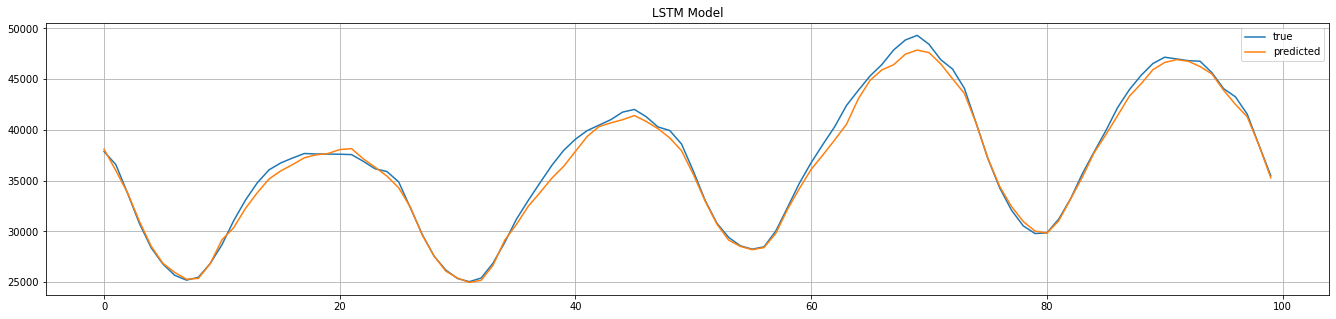

In [ ]:
y_predicted_bi = [x[3] for x in y_bi_lstm_predictions]
rmse_lstm,mae_lstm,mape_lstm,mse_lstm = performance_metrics(y_te,y_predicted_bi)
print('RSME :',rmse_lstm)
print('MAE :',mae_lstm)
print('MAPE :',mape_lstm)
print('MSE :',mse_lstm)

result_visualization(y_te,y_predicted_bi,title='LSTM Model')

## Observation/Results:

In [1]:
from prettytable import PrettyTable
result = PrettyTable()
result.field_names = ["Model","RMSE","MAE","MAPE","MSE"]
result.add_row(["Single Exponential Smoothing",7092.239,5901.14,18.035,50299861.325])
result.add_row(["Double Exponential Smoothing",29785.363,26662.482,69.994,88716892.727])
result.add_row(["Triple Exponential Smoothing",4069.104,3364.450,8.771,16557612.352])
result.add_row(["AR Model without Differencing",526.066,392.75,1.089,276745.63])
result.add_row(["MA Model without Differencing",3559.060,2653.37,8.12,12666914.43])
result.add_row(["ARMA Model",874.643,454.01,1.228,765000.83])
result.add_row(["AR Model with Differencing",895.068,476.27,1.310,801148.41])
result.add_row(["MA Model with Differencing",951.931,536.34,1.503,906173.18])
result.add_row(["ARIMA Model",844.341,477.26,1.298,712912.48])
result.add_row(["SAR Model",795.254,435.6,1.220,632430.46])
result.add_row(["SMA Model",5249.52,4477.46,11.884,27557700.54])
result.add_row(["SARMA Model",291.889,224.752,0.608,85199.325])
result.add_row(["SARIMA Model",275.517,212.768,0.5627,75910.100])
result.add_row(["FBProphet Model",668.407,3068.529,8.545,13457211.092])
result.add_row(["Dummy Regressor",6632.972,5486.560,15.984,43996517.740])
result.add_row(["SVR Model",1083.289,857.432,2.362,1173517.066])
result.add_row(["LightGBM",686.671,534.311,1.431,471929.971])
result.add_row(["SGD Linear Regression",989.402,873.323,2.411,978916.694])
result.add_row(["Random Forest Model",274.871,198.227,0.539,75554.60])
result.add_row(["Decision Tree Model",376.428,287.050,0.789,141698.248])
result.add_row(["KNN Model",360.854,292.356,0.799,130244.830])
result.add_row(["LSTM Model",323.641,258.908,21.656,104743.853])
result.add_row(["Bidirectional LSTM Model",604.121,449.273,1.167,364962.501])
print(result)

+--------------------------------------------+-----------+-----------+--------+--------------+
|                   Model                    |    RMSE   |    MAE    |  MAPE  |     MSE      |
+--------------------------------------------+-----------+-----------+--------+--------------+
|        Single Exponential Smoothing        |  7092.239 |  5901.14  | 18.035 | 50299861.325 |
|        Double Exponential Smoothing        | 29785.363 | 26662.482 | 69.994 | 88716892.727 |
|        Triple Exponential Smoothing        |  4069.104 |  3364.45  | 8.771  | 16557612.352 |
|       AR Model without Differencing        |  526.066  |   392.75  | 1.089  |  276745.63   |
|       MA Model without Differencing        |  3559.06  |  2653.37  |  8.12  | 12666914.43  |
|                 ARMA Model                 |  874.643  |   454.01  | 1.228  |  765000.83   |
|         AR Model with Differencing         |  895.068  |   476.27  |  1.31  |  801148.41   |
|         MA Model with Differencing         |  95

From above observation/results it is evident that **Random Forest Model** & **SARIMA Model** has better RMSE,MAE,MAPE,MSE.Though for random forest model we need some extra features while sarima model the given data is only enough but the time to train the random forest is very very less than sarima model and since after deploying the model we need to retrain the model time to time random forest win the case.So for prediction of future datapoints we would be considering **Random Forest Model** 